# Import necessary libraries

In [1]:
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [2]:
str_col = ['reference', 'translation']
num_col = ['ref_tox', 'trn_tox', 'similarity', 'lenght_diff']

data = pd.read_csv("data/interim/preprocessed_filtered_1.tsv", sep='\t', index_col=0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577777 entries, 0 to 577776
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   reference    577777 non-null  object 
 1   translation  577777 non-null  object 
 2   ref_tox      577777 non-null  float64
 3   trn_tox      577777 non-null  float64
 4   similarity   577777 non-null  float64
 5   length_diff  577777 non-null  float64
dtypes: float64(4), object(2)
memory usage: 30.9+ MB


# Prepare Dataloader

In [4]:
from src.data.make_dataset import prepareData, get_dataloader, tensorFromSentence

# Define models

In [5]:
from src.models.attention import Attention, Encoder, Decoder

# Train model

In [6]:
from src.models.train_model import train

In [7]:
epochs = 15
n_head = 8
embed_size = 256
hidden_size = 256
batch_size = 128
lr = 3e-4
MAX_LENGTH = 24
model_path = "attention.pt"

teacher_force = 1.0
teacher_decay = 0.9
teacher_epoch = 1

vocab_tox, vocab_detox, pairs = prepareData(data, MAX_LENGTH)
train_dataloader, val_dataloader = get_dataloader(batch_size, vocab_tox, vocab_detox, pairs, MAX_LENGTH, device=device)

Counted words:
tox-vocab 55753
detox-vocab 50746


In [8]:
encoder = Encoder(vocab_tox.n_words, batch_size, embed_size, hidden_size, vocab_tox, device=device, max_length=MAX_LENGTH)
decoder = Decoder(n_head, batch_size, embed_size, hidden_size, vocab_detox.n_words, vocab_detox, device=device, max_length=MAX_LENGTH)
model = Attention(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=vocab_detox.word2index['<pad>'])

print(sum(p.numel() for p in model.parameters())/1e6, 'Million parameters')

loss_train, loss_val = train(
    model, 
    train_dataloader, 
    val_dataloader, 
    optimizer=optimizer, 
    criterion=criterion, 
    epochs=epochs, 
    lr=lr, 
    model_path=model_path,
    teacher_force=teacher_force,
    teacher_decay=teacher_decay,
    teacher_epoch=teacher_epoch,
)

41.554746 Million parameters


Epoch 15: val: 100%|██████████| 393/393 [00:19<00:00, 19.97it/s, loss=3.72]


# Plot loss

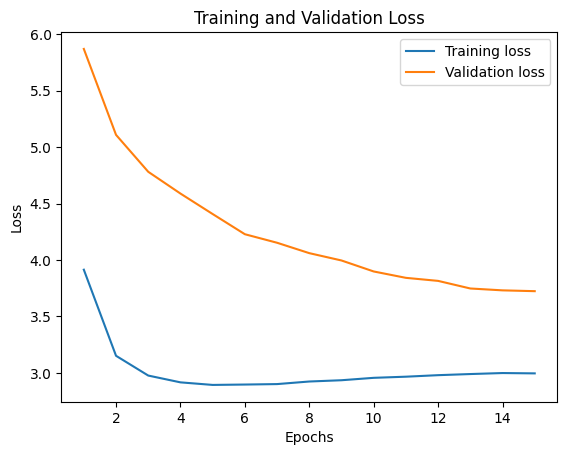

In [9]:
from src.visualization.visualize import plot_loss

plot_loss(loss_train, loss_val, epochs)

# Check in random sample from dataset

In [10]:
def evaluate(model, sentence, vocab_tox, vocab_detox):
    with torch.no_grad():
        model.eval()
        input_tensor = tensorFromSentence(vocab_tox, sentence, device=device)

        outputs = model(input_tensor)

        _, topi = outputs.topk(1)
        ids = topi.squeeze()

        words = []
        for idx in ids:
            if idx.item() == vocab_detox.word2index['<eos>']:
                break
            words.append(vocab_detox.index2word[idx.item()])
    return words

In [11]:
import random
import string

def evaluateRandomly(model, vocab_tox, vocab_detox, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('origin:     ', pair[0])
        print('translated: ', pair[1])
        output_words = evaluate(model, pair[0], vocab_tox, vocab_detox)
        output_sentence = "".join([" "+i if not i.startswith("'") and not i.startswith("n'") and i not in string.punctuation else i for i in output_words]).strip()
        print('predicted:  ', output_sentence)
        print('')

In [32]:
load_model = torch.load(model_path)

load_model.eval()
evaluateRandomly(load_model, load_model.encoder.vocab, load_model.decoder.vocab)

origin:      is there a point to your bluster , prime ?
translated:  does this shit have a point , prime ?
predicted:   you you,,,,,,,,?

origin:      he was a different kid .
translated:  it was just another dumb little kid .
predicted:   he was a a kid.

origin:      i am afraid i have no choice but to evacuate the planet and have them destroyed .
translated:  unfortunately , i have no choice but to evacuate the planet and let them exterminate them .
predicted:   i have no choice but to evacuate the planet and destroy them.

origin:      i am the star of a cop !
translated:  i am a fucking star !
predicted:   a cop cop cop cop cop!

origin:      that is the bad chalk !
translated:  its this wretched chalk !
predicted:   you is a detonator!!

origin:      your heart your liver your eyes if you start threatening me , i will go to the police !
translated:  your heart your liver and your eyes , if you keep blackmailing me , i will call the police !
predicted:   your heart will your eyes 